# Creating baseline performance for MPI


In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
#import hvplot.xarray
import sys

%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

sys.path.insert(0, '../../src')

from utils import df_to_xarray,read_xarray

In [47]:
can_data_path = "../../data/can_001"

def read_xarray_can(dir_name=""):
    '''
     read_xarray(dir)name) opens data and returns data in xarray format for each feature mpi
    '''
    date="198201-201712"
  
    file_type ="CanESM2r1r10"
    #Chl_2D_mon_CanESM2r1r10_1x1_198201-201712.nc
        
    chl = xr.open_dataset(f'{dir_name}/Chl_2D_mon_{file_type}_1x1_{date}.nc')

    mld = xr.open_dataset(f'{dir_name}/MLD_2D_mon_{file_type}_1x1_{date}.nc')

    sss = xr.open_dataset(f'{dir_name}/SSS_2D_mon_{file_type}_1x1_{date}.nc')

    sst = xr.open_dataset(f'{dir_name}/SST_2D_mon_{file_type}_1x1_{date}.nc')

    xco2 = xr.open_dataset(f'../../data/member_001/XCO2_1D_mon_CESM001_native_198201-201701.nc')

    pco2 = xr.open_dataset(f'{dir_name}/pCO2_2D_mon_{file_type}_1x1_{date}.nc')

    return chl,mld,sss,sst,xco2,pco2


chl,mld,sss,sst,xco2,pco2 = read_xarray_can(can_data_path)

xco2['time'] = xco2.indexes['time'].to_datetimeindex().strftime("%Y-%m")

/tmp/ipykernel_881379/2487652354.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  xco2['time'] = xco2.indexes['time'].to_datetimeindex().strftime("%Y-%m")


In [48]:
xco2['time']

<xarray.DataArray 'time' (time: 421)>
array(['1982-02', '1982-03', '1982-04', ..., '2016-12', '2017-01', '2017-02'],
      dtype=object)
Coordinates:
    TLONG    float64 ...
    TLAT     float64 ...
  * time     (time) object '1982-02' '1982-03' '1982-04' ... '2017-01' '2017-02'

In [49]:
xco2_df = pd.DataFrame()
xco2_df["XCO2"] = xco2.XCO2
xco2_df.index = xco2.time

data_read=xr.merge([mld.MLD,mld.MLD_socat,chl.Chl,chl.Chl_socat,sst.SST,sst.SST_socat,sss.SSS,sss.SSS_socat])
#data_read=xr.merge([mld.MLD,chl.Chl,sst.SST,sss.SSS])



tmp_data=data_read.to_dataframe().reset_index()
tmp_data["time"] = tmp_data["time"].astype("string")
tmp_data["time"] = pd.to_datetime(tmp_data["time"], format='%Y-%m')
tmp_data["time"] = tmp_data["time"].dt.strftime("%Y-%m")
tmp_data = xco2_df.join(tmp_data.set_index('time'),how = "right")

In [50]:
tmp_data

,XCO2,xlon,ylat,MLD,MLD_socat,Chl,Chl_socat,SST,SST_socat,SSS,SSS_socat
1982-01,NaN,0.5,-89.5,NaN,NaN,0.000000,0.0,NaN,NaN,0.000000,0.0
1982-01,NaN,0.5,-88.5,NaN,NaN,0.000000,0.0,NaN,NaN,0.000000,0.0
1982-01,NaN,0.5,-87.5,NaN,NaN,0.000000,0.0,NaN,NaN,0.000000,0.0
1982-01,NaN,0.5,-86.5,NaN,NaN,0.000000,0.0,NaN,NaN,0.000000,0.0
1982-01,NaN,0.5,-85.5,NaN,NaN,0.000000,0.0,NaN,NaN,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2017-01,406.971283,359.5,85.5,59.140614,0.0,0.003955,0.0,-1.942297,-0.0,31.165861,0.0
2017-01,406.971283,359.5,86.5,59.900677,0.0,0.003471,0.0,-1.946234,-0.0,31.213215,0.0
2017-01,406.971283,359.5,87.5,64.020699,0.0,0.002789,0.0,-1.942969,-0.0,31.304342,0.0
2017-01,406.971283,359.5,88.5,71.232010,0.0,0.002264,0.0,-1.932410,-0.0,31.382473,0.0


In [51]:
tmp_data = tmp_data.reset_index()
pco2_data = pco2.pCO2.to_dataframe().reset_index()
pco2_data_socat = pco2.pCO2_socat.to_dataframe().reset_index()

# tmp_data["Chl_socat"]=chl_data_socat["Chl_socat"]
# tmp_data["Chl"]=chl_data["Chl"]
tmp_data["pCO2_socat"]=pco2_data_socat["pCO2_socat"]
tmp_data["pCO2"]=pco2_data["pCO2"]

features_socat = ['xlon', 'ylat','MLD_socat', 'SST_socat', 'SSS_socat','Chl_socat', 'XCO2','pCO2_socat']
features = ['xlon', 'ylat','MLD','SST','SSS','Chl','XCO2','pCO2']

# create separate dataframe for socat
combined_socat=tmp_data[features_socat]
combined=tmp_data[features]

In [52]:
# drop rows where pco2 or pco2_socat == NA or 0
combined_socat.dropna(subset = ["pCO2_socat"], inplace=True)
combined_socat= combined_socat[combined_socat['pCO2_socat']!=0]

combined.dropna(subset = ["pCO2"], inplace=True)
combined.dropna(subset = ["SSS"], inplace=True)
combined.dropna(subset = ["XCO2"], inplace=True)

combined = combined[combined['pCO2']!=0]

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [53]:
combined.isna().sum()

xlon          0
ylat          0
MLD     6911100
SST     6911100
SSS           0
Chl           0
XCO2          0
pCO2          0
dtype: int64

In [54]:
X_socat=combined_socat.iloc[:,3:-1]
X=combined.iloc[:,3:-1]
X_socat=combined_socat.iloc[:,:-1]
X=combined.iloc[:,:-1]
y=combined.loc[:,'pCO2']
y_socat=combined_socat.loc[:,'pCO2_socat']



In [55]:
X.head()

,xlon,ylat,MLD,SST,SSS,Chl,XCO2
68929,22.5,79.5,NaN,NaN,0.000000,0.000000,340.848541
68930,22.5,80.5,NaN,NaN,0.386279,0.000020,340.848541
68931,22.5,81.5,46.335178,-1.961218,32.471485,0.001703,340.848541
68932,22.5,82.5,50.894016,-1.946143,32.015755,0.001678,340.848541
68933,22.5,83.5,56.289417,-1.931982,31.641172,0.001276,340.848541


In [56]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X=imp.fit_transform(X)
X_socat=imp.fit_transform(X_socat)

In [57]:

X_train, X_test, y_train, y_test = train_test_split(X_socat, y_socat, test_size=0.3, random_state= 73)

regressor=RandomForestRegressor(n_estimators=20, random_state=42, verbose=3,n_jobs=-1, 
                                max_depth=10,warm_start= True)
regressor.fit(X_train, y_train)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

forest_scores = cross_val_score(regressor, X_train, y_train,
                                scoring="neg_mean_squared_error", cv=3)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[P

Scores: [43.88102712 42.62739679 43.40265507]
Mean: 43.30369299288091
Standard deviation: 0.5165542064153791


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


In [58]:
y_pred=regressor.predict(X_test)
test_mse=mean_squared_error(y_test, y_pred,squared=True)
np.sqrt(test_mse)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


43.86866231447536

In [59]:
y_pred=regressor.predict(X)
final_test_rmse=np.sqrt(mean_squared_error(y, y_pred,squared=True))
error=y-y_pred

final_test_rmse

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    2.2s finished


68.2043680501978

In [60]:
predicted_df = pd.DataFrame(X, columns = ['xlon', 'ylat','MLD','SST','SSS','Chl','XCO2'])
predicted_df["pred"] = y_pred

In [61]:
new_df = pd.merge(tmp_data, predicted_df,  how='left', left_on=['xlon', 'ylat','MLD','SST','SSS','Chl','XCO2'], right_on = ['xlon', 'ylat','MLD','SST','SSS','Chl','XCO2'])


In [62]:
res = new_df.pCO2 - new_df.pred

In [63]:
col_names = ["time","lon","lat","pred"]

pred_df = new_df[["index","xlon","ylat","pred"]]
pred_df.columns = col_names
pred_df['time'] = pd.to_datetime(pred_df['time'])
pred_df = pred_df.set_index(["time","lat","lon"])


col_names = ["time","lon","lat","res"]

res_df = new_df[["index","xlon","ylat"]]
res_df["residual"]=res
res_df.columns = col_names
res_df['time'] = pd.to_datetime(res_df['time'])
res_df = res_df.set_index(["time","lat","lon"])


pred_xarray = pred_df.to_xarray()
res_xarray = res_df.to_xarray()



/tmp/ipykernel_881379/3780070735.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['time'] = pd.to_datetime(pred_df['time'])
/tmp/ipykernel_881379/3780070735.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df["residual"]=res
/tmp/ipykernel_881379/3780070735.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [64]:
pred_xarray

<xarray.Dataset>
Dimensions:  (time: 421, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2017-01-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    pred     (time, lat, lon) float64 nan nan nan nan ... 377.4 377.4 377.4

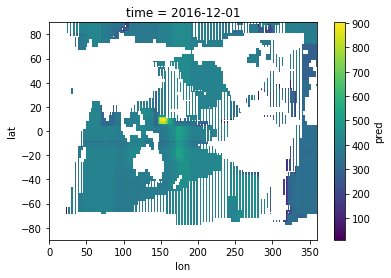

In [65]:

pred_xarray.pred[419].plot()

plt.show()

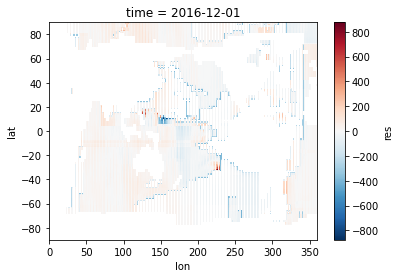

In [66]:
res_xarray.res[419].plot()

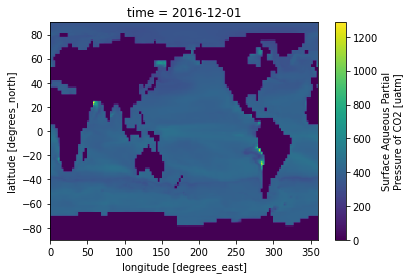

building tree 4 of 20
building tree 5 of 20
building tree 10 of 20
building tree 16 of 20
building tree 20 of 20
building tree 4 of 20
building tree 8 of 20
building tree 15 of 20
building tree 16 of 20
building tree 19 of 20
building tree 2 of 20
building tree 7 of 20
building tree 11 of 20
building tree 12 of 20
building tree 19 of 20
building tree 3 of 20
building tree 7 of 20
building tree 11 of 20
building tree 14 of 20
building tree 18 of 20
building tree 2 of 20
building tree 6 of 20
building tree 13 of 20
building tree 14 of 20
building tree 18 of 20
building tree 3 of 20
building tree 6 of 20
building tree 13 of 20
building tree 14 of 20
building tree 18 of 20
building tree 2 of 20
building tree 8 of 20
building tree 12 of 20
building tree 15 of 20
building tree 19 of 20
building tree 3 of 20
building tree 7 of 20
building tree 11 of 20
building tree 12 of 20
building tree 20 of 20
building tree 4 of 20
building tree 8 of 20
building tree 15 of 20
building tree 16 of 20
buildi

In [67]:
pco2.pCO2[419].plot()